In [3]:
# initialize libraries
import glob
import pandas as pd
from math import *

# environment/conversion variables
rho = 0.00237
wattsToFtLbPerSec = 0.74

# define motor
efficiency = 0.9 # would like to curve this too based on some real motor data

# define battery
ampLimit = 10
voltage = 10.5 # ultimately should be curve, not flat
craftWeight = 1.1 # lb

availablePower = efficiency*ampLimit*voltage

#
# Hoping to plot using bokeh

In [4]:
def checkForPowerNeeded(rpm, data):
    rps = rpm/60
    j = flightSpeed/(rps*(diameter))
    data = interpolate(j, data)
    cp = float(data[data.J == j]['CP'].tail(1)) # we need to tail() here because sometimes we get two rows.
    # TODO should probably fix that line above eventually
    powerNeeded = cp * rho * rps**3 * diameter**5 / wattsToFtLbPerSec
    return powerNeeded

def checkThrust(rpm, data):
    rps = rpm/60
    j = flightSpeed/(rps*(diameter))
    data = interpolate(j, data)
    try:
        ct = float(data[data.J == j]['CT'].tail(1)) # we need to tail() here because sometimes we get two rows.
        # TODO should probably fix that line above eventually
    except TypeError:
        debug(j)
        debug(data)
        debug(data[data.J == j]['CT'].tail(1))
    thrust = ct * rho * rps**2 * diameter**4
    return thrust

def checkEta(rpm, data):
    rps = rpm/60
    j = flightSpeed/(rps*(diameter))
    data = interpolate(j, data)
    eta = float(data[data.J == j]['eta'].tail(1)) # we need to tail() here because sometimes we get two rows.
    # TODO should probably fix that line above eventually
    return eta

def interpolate(j, data):
    newRow = pd.Series([j],index=['J'])
    data = data.append(newRow,ignore_index=True)
    data.set_index('J', inplace=True)
    data.sort_index(inplace=True)
    data.interpolate(inplace=True)
    data.reset_index(inplace=True)
    return data

def debug(string):
    # print(string)
    a = 1
def info(string):
    # print(string)
    a = 1

In [5]:
# define flight regimes
regimes = {}

# takeoff
regimes['takeoff'] = {'min thrust': 0.7, 'flight speed': 20, 'gees': 1}


# climb
v = 35 # fps
PoverW = 45 # w/lb
p = PoverW * craftWeight
thrust = p/v*wattsToFtLbPerSec
regimes['climb'] = {'min thrust': thrust, 'flight speed': v, 'gees': 1}

# cruise
v = 55 # fps
PoverW = 45 # w/lb
p = PoverW * craftWeight
thrust = p/v*wattsToFtLbPerSec
regimes['cruise'] = {'min thrust': thrust, 'flight speed': v, 'gees': 1}
def later():

    # drop
    v = 35 # fps
    PoverW = 20 # w/lb
    p = PoverW * craftWeight
    thrust = p/v*wattsToFtLbPerSec
    regimes['drop'] = {'min thrust': thrust, 'flight speed': v, 'gees': 1}


    # turn
    v = 50 # fps
    PoverW = 45 # w/lb # TODO recalculate based on 4G turn
    p = PoverW * craftWeight
    thrust = p/v*wattsToFtLbPerSec
    regimes['turn'] = {'min thrust': thrust, 'flight speed': v, 'gees': 1}


In [6]:
propellorsTooSmall = 0
propellorsTooBig = 0
staticThrustEntries = 0
prematureBreakouts = 0
geometries = 0

minDiameter = 4 # in
maxDiameter = 12 # in

# final data storage
masterDict = {}

# TODO need to add a provision to skip point if j value is not on the data
for regimeName, regime in regimes.items():
    print(regimeName)

    newLineItems = []
    propTag = ""
    newLineItem = ""
    
    for filename in glob.glob("./UIUC-propDB/good-data/*.txt"):
        if "geom" in filename:
            geometries += 1
            continue
        if "static" in filename:
            staticThrustEntries += 1
            continue
            
        # get propellor specs
        data = pd.read_table(filename, sep="\s+")
        dimensions = (filename.split("_"))
        diameter = float(dimensions[1].split("x")[0])/12 # in feet
        pitch = float(dimensions[1].split("x")[1])
        propName = dimensions[0].split("\\")[1]
        dataRPM = dimensions[-1].split(".")[0]
        debug(propName + " " + dimensions[1].split("x")[0] + " x " + str(pitch) + " @ " + dataRPM + " RPM")
        
        if diameter*12 > maxDiameter or diameter*12 < minDiameter:
            continue
            
        newPropTag = propName + " " + dimensions[1].split("x")[0] + " x " + str(pitch)
        if (newPropTag != propTag):
            # we're at a new propellor
            propTag = newPropTag
            print (propTag)
            rpmDiff = 50000
            # if this isn't the very beginning, add previous propellor's top line item to list
            if newLineItem != "":
                newLineItems.append(newLineItem)


        # we need the maximum and minimum j values to bound our possible ranges
        buffer = data.tail(1)['J']
        maxJ = float(buffer.values)
        buffer = data.head(1)['J']
        minJ = float(buffer.values)           
        
        debug(data)
        debug(minJ)
        debug(maxJ)
        
        flightSpeed = regime['flight speed']
        
        # for debugging
        rpms = []
        powers = []

        #
        # find rpm, rps
        #
        minRpm = flightSpeed/(diameter*maxJ)*60
        maxRpm = flightSpeed/(diameter*minJ)*60
        
        #
        # quickly iterate to find rpm
        lowGuess = minRpm
        highGuess = maxRpm
        guessRPM = (lowGuess + highGuess)/2
        
        powerHad = efficiency*ampLimit*voltage
        shaftPower = checkForPowerNeeded(guessRPM, data)
        
        # just to make sure we don't have infinite loop
        c = 1
        
        # make sure we can spin at a range where this power exists
        if checkForPowerNeeded(floor(maxRpm), data) < powerHad:
            debug("This propellor is not valid for our power - propellor cannot use all available power at given RPM range")
            propellorsTooSmall += 1
            continue
            
        elif checkForPowerNeeded(ceil(minRpm), data) > powerHad:
            debug("This propellor is not valid for our power - not enough power to reach minimum RPMs")
            propellorsTooBig +=1
            continue
        
        # looks like we are on the chart! Keep going till we find RPM
        while abs(shaftPower - powerHad) > 0.2:
            c +=1

            if shaftPower > powerHad:
                highGuess = guessRPM

            else:
                lowGuess = guessRPM

            guessRPM = (lowGuess + highGuess)/2
            powerHad = efficiency*ampLimit*voltage
            shaftPower = checkForPowerNeeded(floor(guessRPM), data)

            if c > 400:
                debug("breaking out!")
                debug("shaftPower: " + str(shaftPower))
                debug("powerHad: " + str(powerHad))
                prematureBreakouts += 1

                break
        theRPM = floor(guessRPM)
        rpms.append(theRPM)
        powers.append(checkForPowerNeeded(theRPM, data))
        
        thrust = "{0:.2f}".format(checkThrust(theRPM, data))
        eta = "{0:.2f}".format(checkEta(theRPM, data))
        
        rps = theRPM/60
        j = flightSpeed/(rps*(diameter))
        
        if (abs(theRPM - float(dataRPM)) < rpmDiff):
            # record thrust, power, rpm, prop tag, prop efficiency, diameter for data sample closest to operating RPM
            newLineItem = {'rpm': theRPM, 'thrust': thrust, 'eta': eta, 'shaft power': shaftPower, 
                           'measured at RPM': dataRPM, 'propTag': propTag, 'j': j, 'diameter': diameter}
            rpmDiff = abs(theRPM - float(dataRPM))
            

    # add dict to list for this prop if we're at the end of the props
    newLineItems.append(newLineItem)
    
    # add list of dicts for this regime
    masterDict[regimeName] = newLineItems
  


takeoff
ance 8.5 x 6.0
ance 8.5 x 7.0
apc29ff 9 x 4.0
apc29ff 9 x 5.0
apccf 7.4 x 8.25
apccf 7.8 x 6.0
apccf 7.8 x 7.0
apce 10 x 5.0
apce 10 x 7.0
apce 11 x 10.0
apce 11 x 5.5
apce 11 x 7.0
apce 11 x 8.5
apce 11 x 8.0
apce 8 x 4.0
apce 8 x 6.0
apce 8 x 8.0
apce 9 x 4.5
apce 9 x 6.0
apce 9 x 7.5
apce 9 x 9.0
apcff 4.2 x 4.0
apcff 9 x 4.0
apcsf 10 x 4.7
apcsf 10 x 7.0
apcsf 11 x 3.8
apcsf 11 x 4.7
apcsf 11 x 7.0
apcsf 8 x 3.8
apcsf 8 x 6.0
apcsf 9 x 3.8
apcsf 9 x 4.7
apcsf 9 x 6.0
apcsf 9 x 7.5
apcsp 10 x 10.0
apcsp 10 x 3.0
apcsp 10 x 4.0
apcsp 10 x 5.0
apcsp 10 x 6.0
apcsp 10 x 7.0
apcsp 10 x 8.0
apcsp 10 x 9.0
apcsp 11 x 3.0
apcsp 11 x 4.0
apcsp 11 x 5.0
apcsp 11 x 6.0
apcsp 11 x 7.0
apcsp 11 x 8.0
apcsp 11 x 9.0
apcsp 4.2 x 2.0
apcsp 7 x 6.0
apcsp 7 x 9.0
apcsp 8 x 10.0
apcsp 8 x 4.0
apcsp 8 x 5.0
apcsp 8 x 6.0
apcsp 8 x 7.0
apcsp 8 x 8.0
apcsp 8 x 9.0
apcsp 9 x 10.0
apcsp 9 x 6.0
apcsp 9 x 7.0
apcsp 9 x 8.0
apcsp 9 x 9.0
da4002 5 x 1.58
da4002 5 x 2.65
da4002 5 x 3.75
da4002 5 x 4.9

In [9]:
# masterDict
cruise = pd.DataFrame(masterDict['cruise'])
climb = pd.DataFrame(masterDict['climb'])
takeoff = pd.DataFrame(masterDict['takeoff'])
# drop = pd.DataFrame(masterDict['drop'])



In [10]:
topCruise = cruise.sort_values('eta').tail(5)
topCruise

,diameter,eta,j,measured at RPM,propTag,rpm,shaft power,thrust
90,0.833333,0.74,0.654870,6013,grcsp 10 x 8.0,6047,94.470390,0.93
125,0.833333,0.74,0.596296,6506,kyosho 10 x 7.0,6641,94.505165,0.95
12,0.916667,0.74,0.614964,5999,apce 11 x 8.5,5854,95.779223,0.97
13,0.916667,0.75,0.592398,5997,apce 11 x 8.0,6077,94.547990,0.98
9,0.916667,0.76,0.673905,5501,apce 11 x 10.0,5342,94.433909,0.96


In [11]:
cruise


,diameter,eta,j,measured at RPM,propTag,rpm,shaft power,thrust
0,0.708333,0.69,0.505515,6914,ance 8.5 x 6.0,9216,94.475555,0.86
1,0.708333,0.71,0.535990,6819,ance 8.5 x 7.0,8692,94.972474,0.92
2,0.750000,0.57,0.433327,6815,apc29ff 9 x 4.0,10154,94.486125,0.72
3,0.750000,0.65,0.484955,6917,apc29ff 9 x 5.0,9073,95.132847,0.84
4,0.616667,0.66,0.607487,6812,apccf 7.4 x 8.25,8809,94.316468,0.83
5,0.650000,0.66,0.526488,6831,apccf 7.8 x 6.0,9643,94.564174,0.85
6,0.650000,0.65,0.554855,6716,apccf 7.8 x 7.0,9150,94.627504,0.84
7,0.833333,0.66,0.472949,6710,apce 10 x 5.0,8373,96.015703,0.88
8,0.833333,0.71,0.552224,6519,apce 10 x 7.0,7171,94.485305,0.89
9,0.916667,0.76,0.673905,5501,apce 11 x 10.0,5342,94.433909,0.96


In [12]:
climb

,diameter,eta,j,measured at RPM,propTag,rpm,shaft power,thrust
0,0.708333,0.57,0.337474,6928,ance 8.5 x 6.0,8785,94.558165,1.13
1,0.708333,0.57,0.351852,6800,ance 8.5 x 7.0,8426,94.346563,1.16
2,0.750000,0.51,0.303030,6811,apc29ff 9 x 4.0,9240,94.654112,1.06
3,0.750000,0.58,0.332265,6907,apc29ff 9 x 5.0,8427,94.333552,1.14
4,0.616667,0.52,0.384922,6794,apccf 7.4 x 8.25,8847,94.397826,1.04
5,0.650000,0.50,0.341266,6831,apccf 7.8 x 6.0,9467,94.516267,1.03
6,0.650000,0.49,0.359294,6723,apccf 7.8 x 7.0,8992,94.375181,0.98
7,0.833333,0.59,0.336898,6707,apce 10 x 5.0,7480,94.639670,1.21
8,0.833333,0.63,0.378208,6531,apce 10 x 7.0,6663,94.566172,1.24
9,0.916667,0.62,0.441323,5007,apce 11 x 10.0,5191,94.503048,1.27


In [13]:
takeoff

,diameter,eta,j,measured at RPM,propTag,rpm,shaft power,thrust
0,0.708333,0.36,0.192382,6928,ance 8.5 x 6.0,8806,94.425437,1.33
1,0.708333,0.40,0.200725,6800,ance 8.5 x 7.0,8440,94.579188,1.32
2,0.750000,0.36,0.178811,6811,apc29ff 9 x 4.0,8948,94.657942,1.34
3,0.750000,0.41,0.189125,6907,apc29ff 9 x 5.0,8460,94.487401,1.34
4,0.616667,0.32,0.216481,6794,apccf 7.4 x 8.25,8989,94.502758,1.15
5,0.650000,0.32,0.194598,6831,apccf 7.8 x 6.0,9487,94.382069,1.14
6,0.650000,0.27,0.208088,6723,apccf 7.8 x 7.0,8872,94.671765,0.99
7,0.833333,0.45,0.196266,6707,apce 10 x 5.0,7337,94.610264,1.49
8,0.833333,0.41,0.215827,6531,apce 10 x 7.0,6672,94.684424,1.46
9,0.916667,0.39,0.253013,5007,apce 11 x 10.0,5174,94.574542,1.36


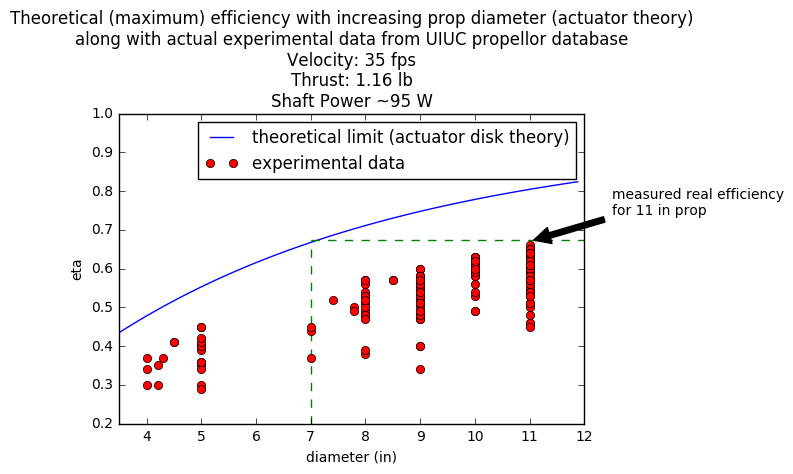

In [75]:
import matplotlib.pyplot as plt
import numpy as np

d = np.arange(0.1,1,0.01)
rho = 0.00237
u0 = 35
thrust = 1.16

eta = 2/(1 + (thrust/(pi*d**2/4*u0**2*rho/2) +1)**(1/2))

etasPlot = plt.figure()

plt.plot(d*12, eta, label = "theoretical limit (actuator disk theory)")
plt.plot([7,12],[0.674,0.674], '--g')
plt.plot([7,7],[0.2,0.674], '--g')
# plt.plot([7,12],[0.57,0.57], '--r')



plt.plot(climb.diameter*12, climb.eta, 'ro', label = "experimental data")
plt.legend()
plt.title("Theoretical (maximum) efficiency with increasing prop diameter (actuator theory)\nalong with actual experimental data from UIUC propellor database\nVelocity: " + str(u0) + " fps\nThrust: " + str(thrust) + " lb\nShaft Power ~95 W")
plt.xlabel("diameter (in)")
plt.ylabel("eta")
plt.xlim([3.5, 12])
plt.ylim([0.2, 1])
plt.annotate('measured real efficiency\nfor 11 in prop', xy=(11, 0.67), xytext=(12.5, 0.74),
            arrowprops=dict(facecolor='black', shrink=0.05),
             )
plt.show(etasPlot)
